## FIR FILTER DEMO
To begin sound playing, execute cell [1].
To stop, restart the kernel.

RadioButtons(description='Signal', index=1, options=(('Input', 0), ('Output', 1)), value=1)

RadioButtons(description='Filter Type', options=(('Moving Average', 0), ('Equiripple (remez)', 1)), value=0)

FloatSlider(value=100.0, description='Frequency (Hz)', max=8000.0, min=30.0)

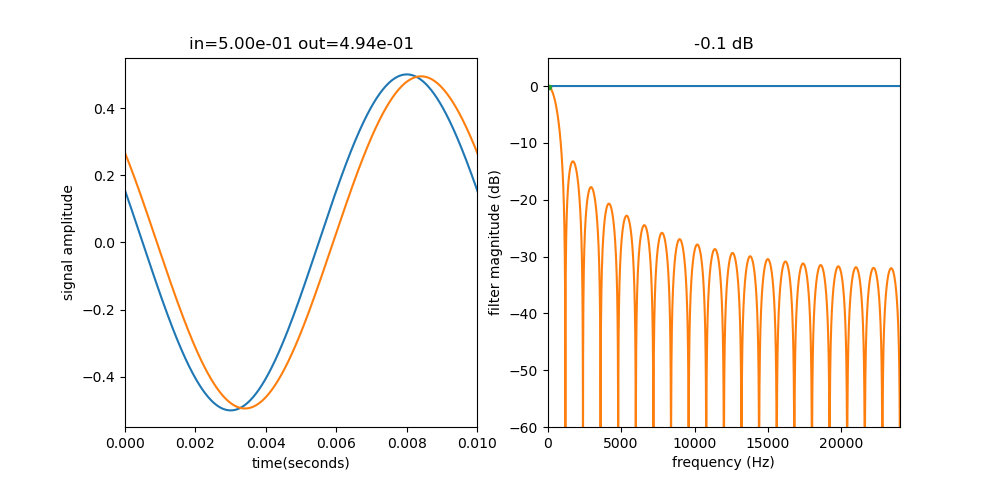

In [1]:
%matplotlib widget

from matplotlib.pyplot import *

import sounddevice as sd
import numpy as np
from scipy.signal import upfirdn

duration = 1.5  # seconds

class AudioGenerator:
    def __init__(self, samplerate, filter_coefficients):
        self.t = 0
        self.biggest = 0
        self.frequency = 100
        self.amplitude = 0.5
        self.samplerate = samplerate
        self.slider_value_last = -1
        self.slider_value = -1
        self.filter_coefficients = filter_coefficients
        self.y = np.array([],dtype=float)
        self.last_yy = np.array([],dtype=float)
        self.signal = 'output'
    
    def callback(self, indata, outdata, frames, time, status):
        if status:
            print(status)
        tt = self.t + np.arange(len(indata))
        y = self.y = self.amplitude*np.cos(tt*2*np.pi*self.frequency/self.samplerate)
        yy = upfirdn(self.filter_coefficients, y)
        if len(self.last_yy)==0:
            self.last_yy = 0*yy
        yy[:len(self.last_yy[len(y):])] += self.last_yy[len(y):] 
        #outdata[:] = indata
        if self.signal == 'output':
            outdata[:,0] = yy[:len(y)]
            outdata[:,1] = yy[:len(y)]
        else:
            outdata[:,0] = y
            outdata[:,1] = y
            
        self.last_yy = yy
        
        self.t += len(indata)
        self.indata_save = indata
        biggest = np.max(np.abs(indata))
        if biggest>self.biggest:
            #print(biggest)
            self.biggest = biggest
        self.args = (indata, outdata, frames, time, status)
        if self.slider_value != self.slider_value_last:
            self.slider_value_last = self.slider_value
            self.frequency = self.slider_value
            
samplerate = 48000
N = 40
h = np.ones((N,))/N

gen = AudioGenerator(samplerate, h)
# def handler(change):
#     # {'name': 'value', 'old': 6, 'new': 5, 'owner': IntSlider(value=5, description='Test:', maxhandle_slider, 'type': 'change'}
#     if change['name'] == 'value':
#         print(change['old'],change['new'])
# slider.observe(handler)
import threading
from IPython.display import display
import ipywidgets as widgets
import time
from scipy.signal import firwin, remez

def handle_slider(gen, linehandle0, linehandle, fig1, linehandle_timedomain1, linehandle_timedomain2, radios1, radios2, th1, th2):
    idx_last = -1
    radios1_last = -1
    radios2_last = -1
    gen.h = np.ones(20)/20
    H = np.fft.fftshift(np.fft.fft(gen.h,nfft))
    update_td = False
    while 1:
        time.sleep(0.05)
        gen.slider_value = slider.get_interact_value()
        idx = np.argmin(abs(f-gen.frequency))
        xdata = f[idx]

        radios1_value = radios1.get_interact_value()

        radios2_value = radios2.get_interact_value()
        if (radios2_last!=radios2_value):
            if radios2_value==1:
                #gen.h = firwin(20, 2500, fs=samplerate)
                gen.filter_coefficients = remez(40, [0, 1500, 5000, samplerate/2], [1,0], fs=samplerate)
            else:
                gen.filter_coefficients = np.ones(40)/40
            H = np.fft.fftshift(np.fft.fft(gen.filter_coefficients,nfft))
            setp(linehandle0,ydata=20*np.log10(abs(H)+1e-20))

        if radios1_value==1:
            gen.signal = 'output'
            ydata = 20*np.log10(abs(H[idx]))
        else:
            gen.signal = 'input'
            ydata = 0.0
                        
        if update_td>0:
            t = np.arange(1000)/samplerate
            x1 = gen.y[:len(t)]
            x2 = gen.last_yy[:len(t)]
            if (len(x1)>0) and (len(x2)>0):
                th2.set_text(f'in={max(x1):1.2e} out={max(x2):1.2e}')            
            if len(gen.y)>=len(t):
                setp(linehandle_timedomain1, xdata=t, ydata=x1)
            if len(gen.last_yy)>=len(t):
                setp(linehandle_timedomain2, xdata=t, ydata=x2)
            fig1.canvas.draw_idle()
            update_td -= 1
                
        if idx != idx_last or (radios1_last!=radios1_value) or (radios2_last!=radios2_value):
            setp(linehandle, xdata=xdata, ydata=ydata)
            th1.set_text(f'{np.round(ydata,decimals=2)} dB')
            
            update_td = 5
        
            fig1.canvas.draw_idle()
            #fig2.canvas.draw_idle()
            
        idx_last = idx
        radios1_last = radios1_value
        radios2_last = radios2_value

        
nfft = 10000
H = np.fft.fftshift(np.fft.fft(h,nfft))
f = (np.arange(nfft)/nfft - 0.5)*samplerate
fig1 = figure()
subplot(1,2,2)
plot(f, 0*abs(H))
lh0 = plot(f, 20*np.log10(abs(H)+1e-20))[0]
setp(gca(), xlim=(0,samplerate/2), ylim=(-60,5))
idx = np.argmin(abs(f-gen.frequency))
lh = plot(f[idx],20*np.log10(abs(H[idx])), '.')[0]
xlabel('frequency (Hz)')
ylabel('filter magnitude (dB)')
th1 = title('x1 x2')

#fig2 = figure()
subplot(1,2,1)
t = np.arange(1000)/samplerate
lh_timedomain1 = plot(t, 0*t)[0]
lh_timedomain2 = plot(t, 0*t)[0]
setp(gca(), xlim=(0,0.01), ylim=(-.55,.55))
xlabel('time(seconds)')
ylabel('signal amplitude')
th2 = title('x dB')
fig1.set_figwidth(10)


stream = sd.Stream(samplerate=samplerate, channels=2, callback=gen.callback)
from ipywidgets import FloatSlider, ToggleButton, IntSlider, RadioButtons
slider = FloatSlider(100.0, min=30., max=8000.0, description='Frequency (Hz)')
slider2 = IntSlider(10, min=1, max=300, description='Filter Length (N)')
#toggle1 = ToggleButton(True, description='Input')
#toggle2 = ToggleButton(True, description='Output')
radios1 = RadioButtons(options=[('Input',0),('Output',1)], index=1, description='Signal')
radios2 = RadioButtons(options=[('Moving Average',0),('Equiripple (remez)',1)], description='Filter Type')

thread = threading.Thread(target=handle_slider, args=(gen, lh0, lh, fig1, lh_timedomain1, lh_timedomain2, radios1, radios2, th1, th2))

display(radios1)
display(radios2)
#display(slider2)
display(slider)
#display(toggle1)
#display(toggle2)
thread.start()
stream.start()
# while 1:
#     sd.sleep(int(duration * 1000))

